In [1]:
import sys; sys.path.append('/Users/brandonliu/Documents/Parkes/transitive-trust-models')
import numpy as np
import matplotlib.pyplot as plt
import studies.efficiency as e; reload(e);
import strategic_trust_models as stm; reload(stm);
from trust_graph import TrustGraph
import operator as op
import time
import math
from scipy import stats
import random
import hitting_time.mat_hitting_time as mht
import random
from collections import defaultdict

In [22]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 21
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['lines.markersize'] = 12.5
plt.rcParams['lines.linewidth'] = 2.5

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)


In [3]:
from IPython.parallel import Client
cli = Client()
lview = cli.load_balanced_view()

In [4]:
# (is_global, name, func)
# Need to keep synced with inside one_compute_mechanism
MECHANISMS = [
    (True, 'Global PageRank', stm.global_pagerank),
    (False, 'Personalized PageRank', stm.person_pagerank),
    (True, 'Global Hitting Time', stm.global_hitting_time),
    (False, 'Personalized Hitting Time', stm.person_hitting_time),
    (True, 'Average Score', stm.average_ratings),
]

In [5]:
@lview.parallel(block=True)
def one_compute_mechanism(args):
    import sys
    sys.path.append('..')
    import studies.efficiency as e; reload(e)
    import strategic_trust_models as stm; reload(stm)
    import networkx as nx
    import random
    from scipy import stats
    import numpy as np
    
    # Need to keep synced with above
    MECHANISMS = [
        (True, 'Global PageRank', stm.global_pagerank),
        (False, 'Personalized PageRank', stm.person_pagerank),
        (True, 'Global Hitting Time', stm.global_hitting_time),
        (False, 'Personalized Hitting Time', stm.person_hitting_time),
        (True, 'Average Score', stm.average_ratings),
    ]
    
    graph, mech_index, sybil_pct, strategic_num = args
    is_global, name, func = MECHANISMS[mech_index]
    N = len(graph)
    
    # crucial to have dtype=int so that we get ints, not numpy.float64
    strategic_agents = np.array(np.arange(0, N, N / float(strategic_num)), dtype=int)
    
    # Calculate the score! (this is the busy part)
    # First calculate the scores with no strategics
    # Then calculate the scores with our strategics
    base_scores = func(graph, 0, sybil_pct)
    new_scores, data = func(graph, strategic_num, sybil_pct, True, True, strategic_agents=strategic_agents, return_data=True)
    
    # Calculate rank changes
    if is_global:
        base_ranks = stats.rankdata(base_scores)
        new_ranks = stats.rankdata(new_scores)
        rank_changes = [new_ranks[agent] - base_ranks[agent] for agent in xrange(len(graph))]
    else:
        # First do ranks
        # xxx_rank[i, j] is the ranking of v_j from v_i's perspective
        base_ranks = np.zeros((N, N))
        for i in xrange(N):
            base_ranks[i] = stats.rankdata(base_scores[i, :N])
        new_ranks = np.zeros((N, N))
        for i in xrange(N):
            new_ranks[i] = stats.rankdata(new_scores[i, :N])
        
        # Now calculate rank changes
        # Take the average rank change from the perspective of every other node
        # v_looking and v_ranked
        rank_changes = [np.round(np.mean([new_ranks[v_looking, v_ranked] - base_ranks[v_looking, v_ranked]
                                 for v_looking in xrange(len(graph)) if v_looking != v_ranked]), 2)
                        for v_ranked in xrange(N)]
    
    
    average_strat_change = np.round(np.mean([rank_changes[agent] for agent in data['strategic_agents']]), 2)
    
    # Helpful data
    if is_global:
        strat_data = [[agent,
                       base_ranks[agent],
                       new_ranks[agent],
                       rank_changes[agent]]
                      for agent in data['strategic_agents']]
    else:
        strat_data = [[agent,
                       np.round(np.mean([base_ranks[v_looking, agent] for v_looking in xrange(N) if v_looking != agent]), 2),
                       np.round(np.mean([new_ranks[v_looking, agent] for v_looking in xrange(N) if v_looking != agent]), 2),
                       rank_changes[agent]]
                     for agent in data['strategic_agents']]
    
    # Efficiency
    efficiency = e.compute_efficiency(graph.agent_types, new_scores, is_global, data['strategic_agents'])
    
    
#     # Calculate ranks based on the scores
#     base_ranks = np.zeros(base_scores.shape)
#     if is_global:
#         base_ranks = stats.rankdata(base_scores)
#     else:
#         for i in xrange(base_scores.shape[0]):
#             base_ranks[i] = stats.rankdata(base_scores[i])
            
#     # Calculate changes in rank. We take starting rank as the ranking of true agent types.
#     if is_global:
#         rank_changes = [base_ranks[agent] - agent for agent in xrange(len(graph))]
#     else:
#         # Average the rank change 
#         rank_changes = [np.mean([base_ranks[v_looking, v_ranked] - v_ranked for v_looking in xrange(len(graph) if v_looking != v_ranked)]) for v_ranked in xrange(len(graph))]
    
            
#     rank_changes = []
#     N = len(graph)
#     for agent in xrange(N):
#         scores = func(graph, 1, sybil_pct, cutlinks, gensybils, strategic_agents=[agent])
#         if is_global:
#             scores = stats.rankdata(scores[:N])
#             rank_changes.append(([base_scores[agent]], [scores[agent]]))
#         else:
#             ranks = np.zeros((N, N))
#             for i in xrange(scores.shape[0]):
#                 ranks[i] = stats.rankdata(scores[i, :N])
#             rank_changes.append((
#                 [base_scores[i, agent] for i in xrange(N) if i != agent],
#                 [ranks[i, agent] for i in xrange(N) if i != agent]
#             ))
    
    return {
        'base_scores': base_scores,
        'base_ranks': base_ranks,
        'new_scores': new_scores,
        'new_ranks': new_ranks,
        'mech_index': mech_index,
        'name': name,
        'is_global': is_global,
        'sybil_pct': sybil_pct,
        'strategic_agents': data['strategic_agents'],
        'average_strat_change': average_strat_change,
        'rank_changes': np.array(rank_changes),
        'strat_data': np.array(strat_data),
        'efficiency': efficiency
    }
        

In [13]:
start = time.time()

# Basic things
ITERS = 3
NODES = 100
EDGES = 20
EDGE_ITERS = 8
graphs = [TrustGraph(NODES, 'uniform', 'cluster', EDGES, 'sample', EDGE_ITERS) for _ in xrange(ITERS)]
sybil_pcts = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
# sybil_pcts = np.hstack([np.arange(0, 0.1, 0.01), np.arange(0.1, 0.72, 0.02)]).tolist()
# sybil_pcts = [0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6]
strategic_num = int(0.2 * NODES)

# args = [[[g, i, m[5], True, False] for g in graphs] for i, m in enumerate(MECHANISMS)]
args = [[[[g, i, sybil_pct, strategic_num] for g in graphs] for sybil_pct in sybil_pcts] for i, m in enumerate(MECHANISMS)]
flattened_args = [val for arr2 in args for arr in arr2 for val in arr]
results = None
results = one_compute_mechanism.map(flattened_args)
results = np.array(results).reshape((len(MECHANISMS), len(sybil_pcts), ITERS))
results_dict = {
    'results': results,
    'args': args,
    'iters': ITERS,
    'nodes': NODES,
    'edges': EDGES,
    'graphs': graphs,
    'sybil_pcts': sybil_pcts,
    'strategic_num': strategic_num,
}
        

print 'elapsed:', time.time() - start

elapsed: 989.982023001


In [13]:
# Used for testing a single mechanism

# graph = results_dict['graphs'][0]
# start = time.time()
# r1 = one_compute_mechanism.func([graph, 1, 0.04, 5])
# print 'elapsed:', time.time() - start

# d50 - first run for 50 nodes, 20 edges, etc...

{'args': [[[[<trust_graph.TrustGraph at 0x137e3e310>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137dfb850>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137e4d8d0>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137e18450>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x13816de10>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x13860a250>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137e0acd0>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137e0ab50>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x138033250>, 0, 0.04, 10],
    [<trust_graph.TrustGraph at 0x137e18390>, 0, 0.04, 10]],
   [[<trust_graph.TrustGraph at 0x137e3e310>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at 0x137dfb850>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at 0x137e4d8d0>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at 0x137e18450>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at 0x13816de10>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at 0x13860a250>, 0, 0.08, 10],
    [<trust_graph.TrustGraph at

In [17]:
MARKERS = ['^', '*', 's', 'o', 'D']

def plot_results(d):
# d = results_dict
# if True:
    shape = d['results'].shape
    rcs = np.zeros(shape[0:2])
    effs = np.zeros(shape[0:2])
    for i in xrange(shape[0]):
        for j in xrange(shape[1]):
            rcs[i, j] = np.mean([d['results'][i, j, k]['average_strat_change'] for k in xrange(shape[2])])
            effs[i, j] = np.mean([d['results'][i, j, k]['efficiency'] for k in xrange(shape[2])])
    
    xs = [int(d['nodes'] * x) for x in d['sybil_pcts']]
    
    # Plot rank changes
    
    for i, (_, name, _) in enumerate(MECHANISMS):
        plt.plot(xs, rcs[i, :], '--' + MARKERS[i], label=name)
    
    plt.legend(loc='best')
    plt.margins(0.07)
    plt.xticks(xs, xs)
    plt.xlabel('# of sybils per strategic agent')
    plt.ylabel('Average rank increase of strategic agents')
    plt.show()
    
    # Plot efficiency
    
    for i, (_, name, _) in enumerate(MECHANISMS):
        plt.plot(xs, effs[i, :], '--' + MARKERS[i], label=name)
    
    plt.legend(loc='best')
    plt.margins(0.07)
    plt.xticks(xs, xs)
    plt.xlabel('# of sybils per strategic agent')
#     plt.ylabel('Efficiency')
    plt.ylabel('Informativeness')
    plt.show()
    


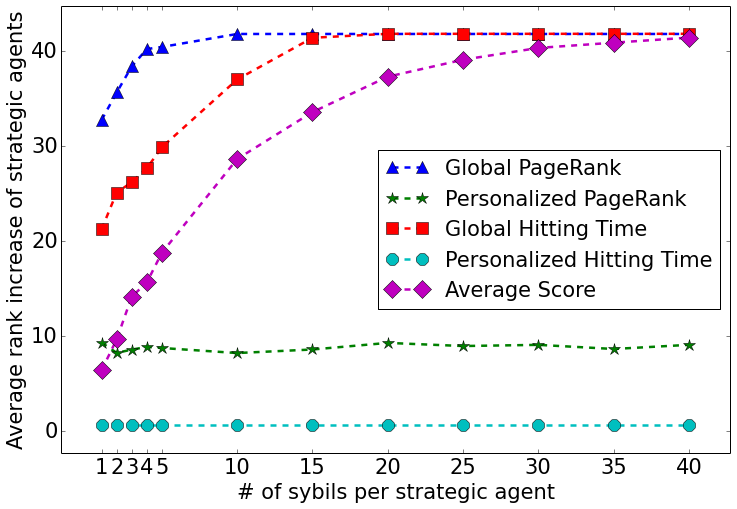

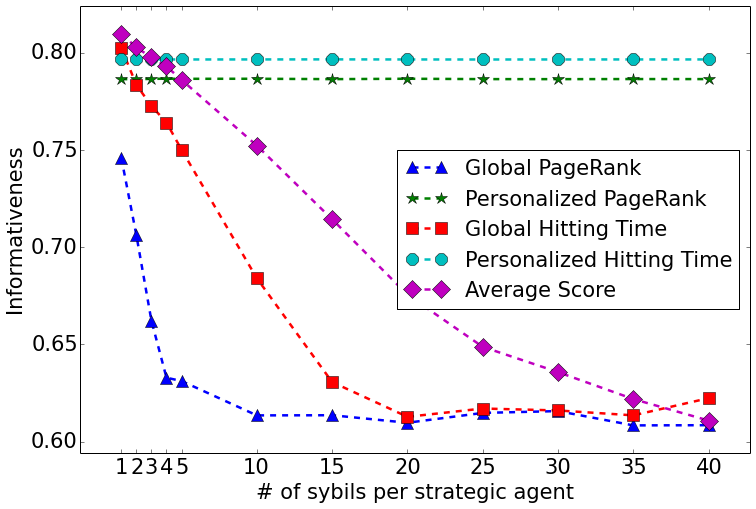

In [23]:
plot_results(results_dict)

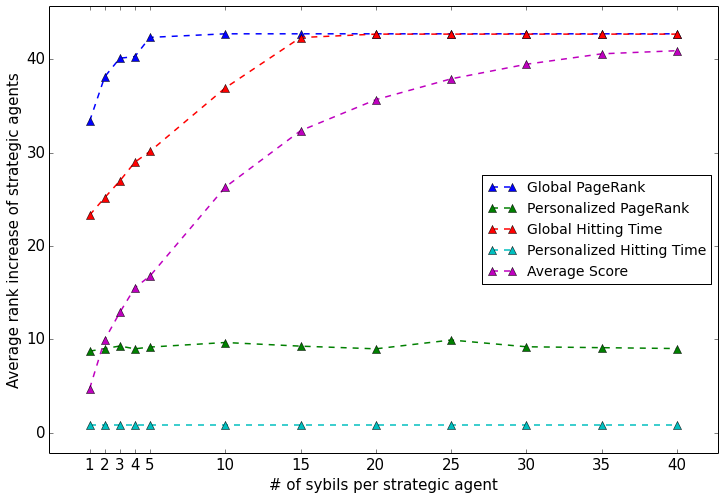

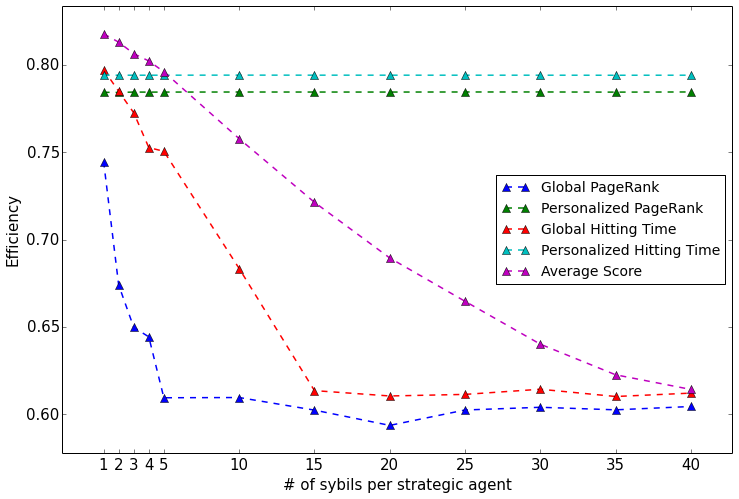

In [25]:
# From the first run? One problem is that it used all the same markers
plot_results(results_dict)